<a href="https://colab.research.google.com/github/sarahrafiqshaikh/Adult-Census-Income-Prediction-Analysis/blob/main/nlp_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3 Project: Submit the code**
**SARAH RAFIQ SHAIKH** </BR>
**B20102144** </BR>
**Implemented** </br>
- **Baseline Model (TF-IDF + Naive Bayes)**
- **BERT (fine tunning) using version of BERT DistilBERT**

**Import Required Libraries**

In [1]:
# Install required packages
!pip install contractions

# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import contractions
from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.3 MB/s eta 0:00:00
Mounted at /content/drive


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

**Text Preprocessing**

In [2]:
def expand_contractions(text):
    return contractions.fix(text)

def handle_negations(text):
    negations = ["not", "no", "never", "n't"]
    words = text.split()
    for i, word in enumerate(words):
        if word.lower() in negations and i + 1 < len(words):
            words[i] = word + "_"
    return ' '.join(words)

def preprocess_text(text):
    text = str(text).lower()
    text = expand_contractions(text)
    text = handle_negations(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-zA-Z\'\s_]', ' ', text)
    text = ' '.join(text.split())
    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    emotional_words = {'not', 'no', 'nor', 'against', "n't", 'never', 'none', 'nobody', 'nothing',
                      'neither', 'nowhere', 'without', 'won', 'can', 'cannot', 'could', 'would',
                      'should', 'must', 'despite', 'feel', 'feeling', 'feelings', 'felt'}
    stop_words = stop_words - emotional_words

    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token, pos='v') for token in tokens]
    tokens = [lemmatizer.lemmatize(token, pos='n') for token in tokens]
    return ' '.join(tokens)

**Load and Prepare Dataset**

In [3]:
print("Loading dataset...")
df = pd.read_csv('/content/drive/MyDrive/Colab_Data/text.csv')

# Create emotion mapping
emotion_mapping = {
    0: 'sadness',
    1: 'worry',
    2: 'love',
    3: 'anger',
    4: 'stress',
    5: 'neutral'
}

# Add emotion names
df['emotion_name'] = df['label'].map(emotion_mapping)

Loading dataset...


**Visualize Original Data Distribution**

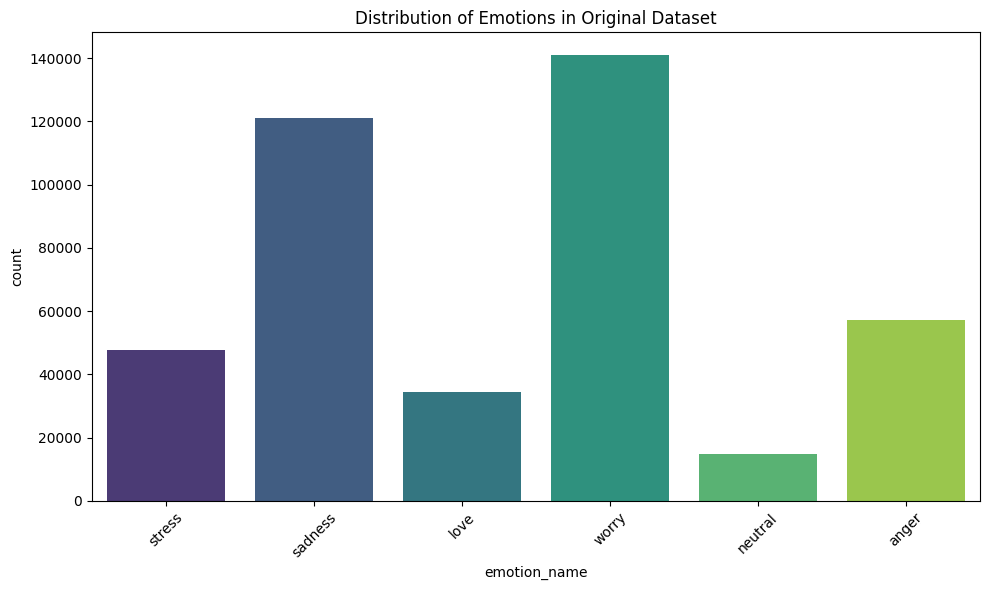

In [4]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='emotion_name', palette='viridis')
plt.title('Distribution of Emotions in Original Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Create Balanced Dataset**

In [5]:
min_class_size = df['label'].value_counts().min()
sample_size = int(min_class_size * 0.8)

balanced_dfs = []
for label in df['label'].unique():
    label_df = df[df['label'] == label]
    sampled_df = label_df.sample(n=sample_size, random_state=42)
    balanced_dfs.append(sampled_df)

balanced_df = pd.concat(balanced_dfs, ignore_index=True)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

**Preprocess Text and Calculate Sentiment**

In [6]:
print("Preprocessing text data...")
balanced_df['processed_text'] = balanced_df['text'].apply(preprocess_text)
balanced_df['sentiment_polarity'] = balanced_df['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

Preprocessing text data...


**Visualize Balanced Dataset**

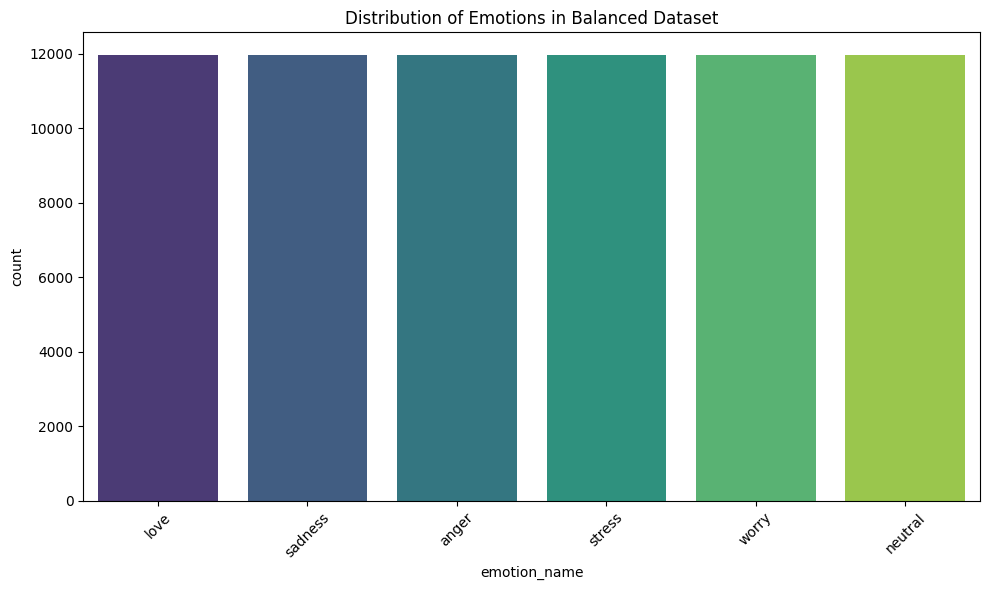

In [7]:
plt.figure(figsize=(10, 6))
sns.countplot(data=balanced_df, x='emotion_name', palette='viridis')
plt.title('Distribution of Emotions in Balanced Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Split Data**

In [8]:
X = balanced_df['processed_text']
y = balanced_df['label']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

**Baseline Model (TF-IDF + Naive Bayes)**

Training Baseline Model...

Baseline Model Classification Report:
              precision    recall  f1-score   support

     sadness       0.90      0.86      0.88      1824
       worry       0.85      0.84      0.85      1787
        love       0.84      0.86      0.85      1779
       anger       0.89      0.87      0.88      1787
      stress       0.84      0.83      0.84      1793
     neutral       0.84      0.89      0.86      1810

    accuracy                           0.86     10780
   macro avg       0.86      0.86      0.86     10780
weighted avg       0.86      0.86      0.86     10780



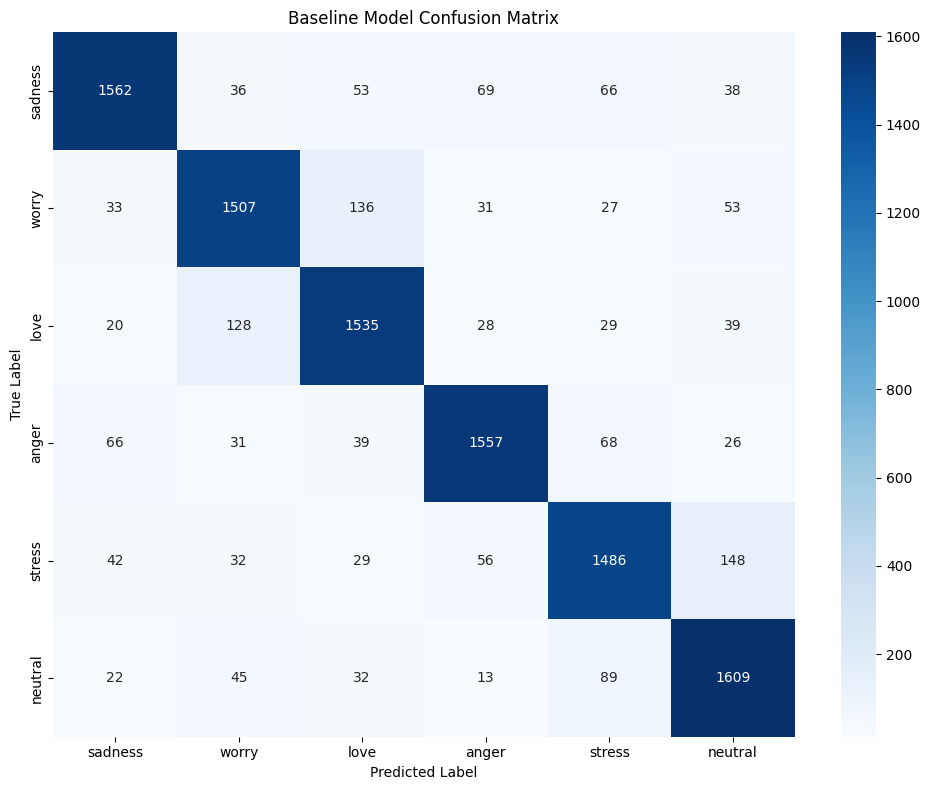

In [9]:
print("Training Baseline Model...")
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

# Train Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Evaluate Baseline Model
baseline_predictions = nb_model.predict(X_test_tfidf)
print("\nBaseline Model Classification Report:")
print(classification_report(y_test, baseline_predictions, target_names=emotion_mapping.values()))

# Plot Baseline Confusion Matrix
plt.figure(figsize=(10, 8))
baseline_cm = confusion_matrix(y_test, baseline_predictions)
sns.heatmap(baseline_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_mapping.values(),
            yticklabels=emotion_mapping.values())
plt.title('Baseline Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

**DistilBERT Model Setup**

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")

class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels.iloc[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }



Using device: cuda


**DistilBERT Training Functions**

In [11]:
def create_data_loader(X, y, tokenizer, batch_size=32):
    dataset = EmotionDataset(X, y, tokenizer)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    losses = []
    correct_predictions = 0
    total_predictions = 0

    progress_bar = tqdm(data_loader, desc='Training')
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_predictions += len(labels)

        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        progress_bar.set_postfix({'loss': np.mean(losses),
                                'accuracy': (correct_predictions/total_predictions).item()})

    return np.mean(losses), (correct_predictions/total_predictions).item()

def evaluate(model, data_loader, device):
    model.eval()
    losses = []
    correct_predictions = 0
    total_predictions = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)

            correct_predictions += torch.sum(preds == labels)
            total_predictions += len(labels)
            losses.append(loss.item())

            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.mean(losses), (correct_predictions/total_predictions).item(), all_predictions, all_labels

**Train DistilBERT Model**

In [12]:
# Initialize model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=6,
    output_attentions=False,
    output_hidden_states=False
).to(device)

# Create data loaders
train_loader = create_data_loader(X_train, y_train, tokenizer)
val_loader = create_data_loader(X_val, y_val, tokenizer)
test_loader = create_data_loader(X_test, y_test, tokenizer)

# Training parameters
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Training loop
print("Starting DistilBERT training...")
train_losses = []
val_losses = []
train_accs = []
val_accs = []
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch + 1}/{EPOCHS}')

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    print(f'Training Loss: {train_loss:.3f}, Training Accuracy: {train_acc:.3f}')

    val_loss, val_acc, val_predictions, val_labels = evaluate(model, val_loader, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_acc:.3f}')

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_model_state = model.state_dict().copy()
        print(f'Best model found with accuracy: {best_accuracy:.3f}')


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting DistilBERT training...

Epoch 1/3


Training: 100%|██████████| 1572/1572 [08:40<00:00,  3.02it/s, loss=0.291, accuracy=0.899]


Training Loss: 0.291, Training Accuracy: 0.899


Evaluating: 100%|██████████| 337/337 [00:39<00:00,  8.58it/s]


Validation Loss: 0.161, Validation Accuracy: 0.942
Best model found with accuracy: 0.942

Epoch 2/3


Training: 100%|██████████| 1572/1572 [08:37<00:00,  3.04it/s, loss=0.142, accuracy=0.946]


Training Loss: 0.142, Training Accuracy: 0.946


Evaluating: 100%|██████████| 337/337 [00:39<00:00,  8.52it/s]


Validation Loss: 0.157, Validation Accuracy: 0.945
Best model found with accuracy: 0.945

Epoch 3/3


Training: 100%|██████████| 1572/1572 [08:30<00:00,  3.08it/s, loss=0.118, accuracy=0.953]


Training Loss: 0.118, Training Accuracy: 0.953


Evaluating: 100%|██████████| 337/337 [00:39<00:00,  8.63it/s]

Validation Loss: 0.159, Validation Accuracy: 0.944


**Evaluate and Compare Models**


Performing final DistilBERT evaluation on test set...


Evaluating: 100%|██████████| 337/337 [00:39<00:00,  8.56it/s]



DistilBERT Model Results:
Test Loss: 0.151
Test Accuracy: 0.947

DistilBERT Classification Report:
              precision    recall  f1-score   support

     sadness       0.98      0.94      0.96      1824
       worry       0.97      0.93      0.95      1787
        love       0.93      0.97      0.95      1779
       anger       0.94      0.96      0.95      1787
      stress       0.94      0.88      0.91      1793
     neutral       0.91      1.00      0.95      1810

    accuracy                           0.95     10780
   macro avg       0.95      0.95      0.95     10780
weighted avg       0.95      0.95      0.95     10780


Baseline Model Classification Report:
              precision    recall  f1-score   support

     sadness       0.90      0.86      0.88      1824
       worry       0.85      0.84      0.85      1787
        love       0.84      0.86      0.85      1779
       anger       0.89      0.87      0.88      1787
      stress       0.84      0.83      0.84    

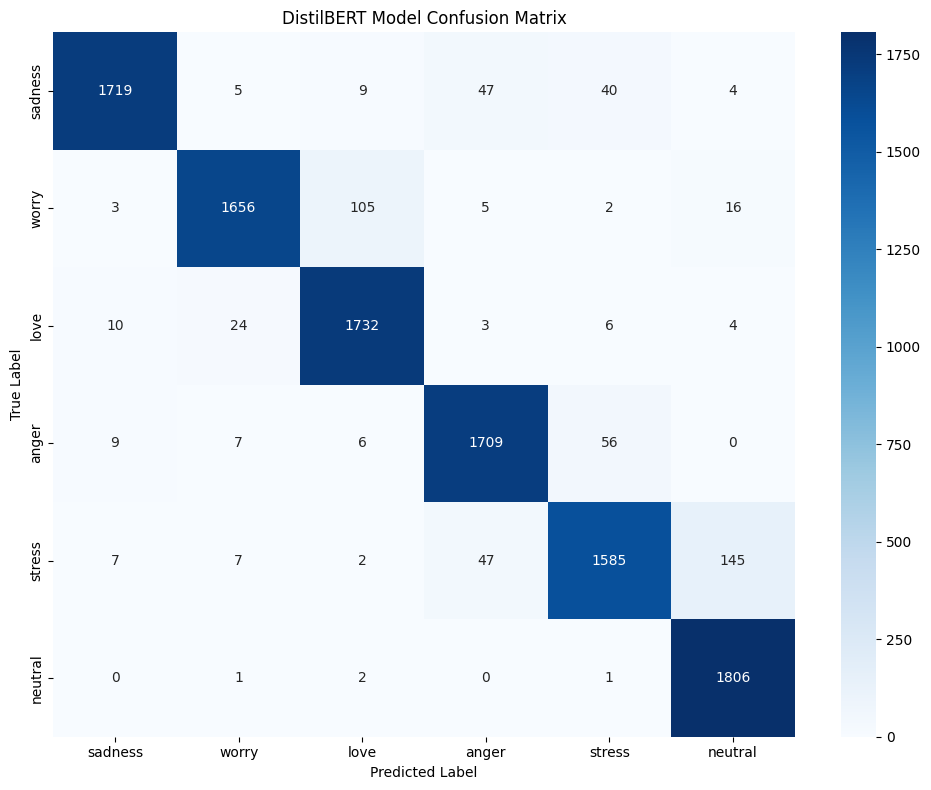

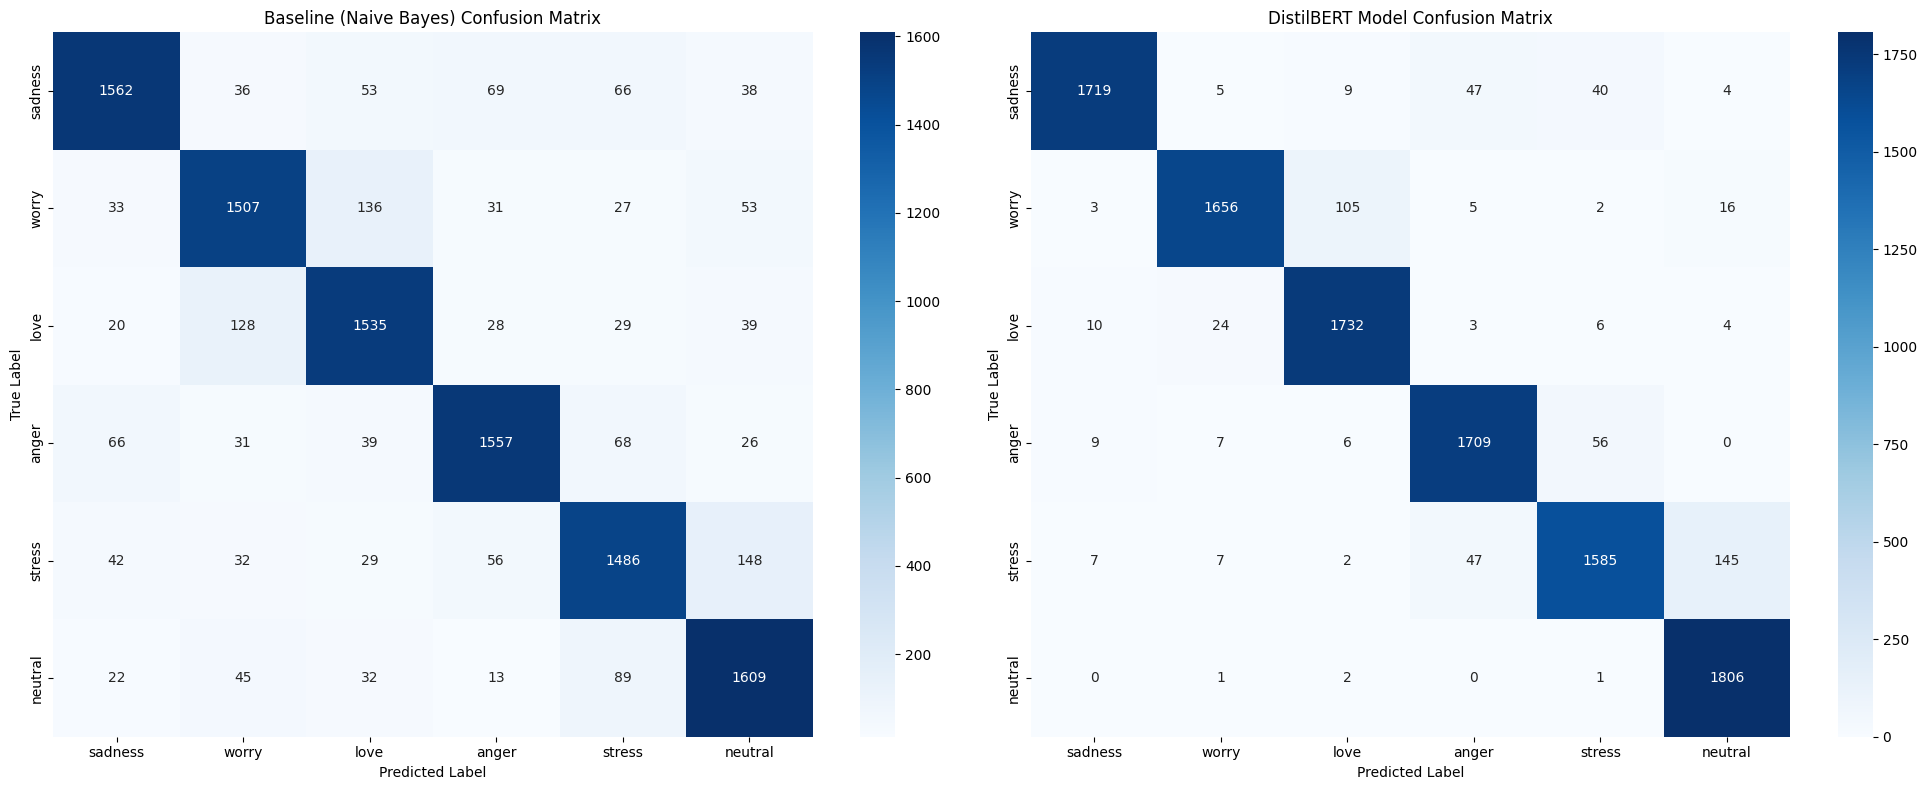


Model Comparison Summary:
-------------------------
Baseline Model Accuracy: 0.859
DistilBERT Model Accuracy: 0.947


In [16]:
# Load best model for final evaluation
model.load_state_dict(best_model_state)

# Final evaluation on test set
print("\nPerforming final DistilBERT evaluation on test set...")
test_loss, test_acc, test_predictions, test_labels = evaluate(model, test_loader, device)

# Print final metrics
print("\nDistilBERT Model Results:")
print(f'Test Loss: {test_loss:.3f}')
print(f'Test Accuracy: {test_acc:.3f}')
print('\nDistilBERT Classification Report:')
print(classification_report(test_labels, test_predictions, target_names=emotion_mapping.values()))

# Get baseline model predictions and classification report
baseline_predictions = nb_model.predict(X_test_tfidf)
print('\nBaseline Model Classification Report:')
print(classification_report(y_test, baseline_predictions, target_names=emotion_mapping.values()))

# Calculate confusion matrices
distilbert_cm = confusion_matrix(test_labels, test_predictions)
baseline_cm = confusion_matrix(y_test, baseline_predictions)

# Plot individual DistilBERT confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(distilbert_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_mapping.values(),
            yticklabels=emotion_mapping.values())
plt.title('DistilBERT Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Plot comparison of confusion matrices side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot Naive Bayes confusion matrix
sns.heatmap(baseline_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_mapping.values(),
            yticklabels=emotion_mapping.values(), ax=ax1)
ax1.set_title('Baseline (Naive Bayes) Confusion Matrix')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

# Plot DistilBERT confusion matrix
sns.heatmap(distilbert_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_mapping.values(),
            yticklabels=emotion_mapping.values(), ax=ax2)
ax2.set_title('DistilBERT Model Confusion Matrix')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Print comparison summary
print("\nModel Comparison Summary:")
print("-------------------------")
print(f"Baseline Model Accuracy: {nb_model.score(X_test_tfidf, y_test):.3f}")
print(f"DistilBERT Model Accuracy: {test_acc:.3f}")

**After implementing and comparing both the baseline model (TF-IDF + Naive Bayes) and DistilBERT for emotion classification**

# **Interpretations**

**Model Performance Comparison:** </br>
Looking at overall accuracy, my DistilBERT model reached **94.7%,** which is a big step up from the **baseline’s 85.9%.** This **8.8-point improvement shows** how much more **effectively transformers can capture the subtle details in emotional text, making a noticeable difference in performance.**

**Analysis of My DistilBERT Implementation:**
 DistilBERT stand out in performance. It achieved **F1-scores between 91% and 96%,** which is excellent for an emotion classification task. The model did particularly well with **sadness (96% F1-score)** and even managed the more challenging emotions like **stress quite well (91% F1-score).**

**Impressing about DISTILBERT**

- Its precision for sadness was amazing at 98%
- It had a perfect recall of 100% for neutral emotions
- The performance was very balanced, especially for anger and love
- **has an overall accuracy of 95%**

**Baseline Model Results:** </br>
- While the baseline model is simpler, it still held its own, with **F1-scores around 84-88% across the board**. It was best at identifying sadness and anger (both with an 88% F1-score), though it struggled a bit more with stress (84% F1-score). Overall, it’s a decent performance for a basic model,.

**Training Process Observations:** </br>
During DistilBERT’s training, I saw steady improvements in accuracy:

- **First epoch**: Training accuracy went up to **89.9%** ,with **validation reaching 94.2%**
- **Second epoch**: Training improved to **94.6% and validation to 94.5%**
- **Third epoch:** Training hit **95.3%**, but validation dropped slightly to 94.4%

**Key Findings:** </br>
One interesting observation is that both models:

- Were most accurate at classifying sadness
- Had the hardest time with stress
- Managed consistent performance across the different emotions, although - - **DistilBERT was clearly the better performer overall (with accuracy of 95%)**